In [9]:
!nvidia-smi

Fri Jan  3 09:25:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:27:00.0 Off |                   On |
| N/A   33C    P0             70W /  250W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [10]:
!sudo apt-get install -y openjdk-11-jdk

# Set Java environment variables
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

# Install H2O (if not already installed)
!pip install h2o

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libice-dev libpthread-stubs0-dev libsm-dev libx11-dev libxau-dev libxcb1-dev
  libxdmcp-dev libxt-dev openjdk-11-jdk-headless x11proto-dev
  xorg-sgml-doctools xtrans-dev
Suggested packages:
  libice-doc libsm-doc libx11-doc libxcb-doc libxt-doc openjdk-11-demo
  openjdk-11-source visualvm
The following NEW packages will be installed:
  libice-dev libpthread-stubs0-dev libsm-dev libx11-dev libxau-dev libxcb1-dev
  libxdmcp-dev libxt-dev openjdk-11-jdk openjdk-11-jdk-headless x11proto-dev
  xorg-sgml-doctools xtrans-dev
0 upgraded, 13 newly installed, 0 to remove and 13 not upgraded.
Need to get 77.1 MB of archives.
After this operation, 90.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 xorg-sgml-doctools all 1:1.11-1.1 [10.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 

In [11]:
import h2o
print(h2o.__version__)
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

3.46.0.6
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv7doc3kf
  JVM stdout: /tmp/tmpv7doc3kf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpv7doc3kf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_hnvf25
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,30
H2O_cluster_allowed_cores:,30
H2O_cluster_status:,"locked, healthy"


1. My contribution mainly lies in extracting holiday features. 
2. I used Fitter to view the data distribution of the target column and used statistical indicators to check the deviation between predicted values and true values.
3. I haven't programmed for many years. I have been learning Python for the past few months, but I am still not very proficient. I have submitted many times. The parameters are not optimal, but I haven't submitted any more times today. If it is helpful, please upvote. Thanks to everyone.

In [12]:
!pip install -U --q /home/onyxia/work/Forecasting_Sticker_Sales/fitter-1.7.1-py3-none-any.whl
!pip install -U --q pycountry
!pip install lightgbm
!pip install catboost
!pip install holidays

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import holidays
import pycountry

from fitter import Fitter
from scipy import stats

SEED = 42
n_splits = 5
n_estimators=1000
early_stopping_rounds = 100
FE_holidays = True

In [14]:
train_data = pd.read_csv(r"/home/onyxia/work/Forecasting_Sticker_Sales/train.csv")
test_data = pd.read_csv(r"/home/onyxia/work/Forecasting_Sticker_Sales/test.csv")
data = pd.read_csv(r"/home/onyxia/work/Forecasting_Sticker_Sales/sample_submission.csv")

print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("data shape :",data.shape)

train_data shape : (230130, 6)
test_data shape : (98550, 5)
data shape : (98550, 2)


In [15]:
train_data.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [16]:
train_data.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [17]:
train_data.isna().sum().sort_values(ascending=False)

num_sold    8871
id             0
date           0
country        0
store          0
product        0
dtype: int64

In [18]:
train_data['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [19]:
train_data = train_data.drop_duplicates()
train_data = train_data.dropna()
print("train_data shape :",train_data.shape)

train_data shape : (221259, 6)


In [20]:
test_data.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [21]:
test_data.isna().sum().sort_values(ascending=False)

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [22]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['Year'] = train_data['date'].dt.year
train_data['Quarter'] = train_data['date'].dt.quarter
train_data['Month'] = train_data['date'].dt.month
train_data['Day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.day_name()
train_data['week_of_year'] = train_data['date'].dt.isocalendar().week

train_data['day_sin'] = np.sin(2 * np.pi * train_data['Day'] / 365.0)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['Day'] / 365.0)
train_data['month_sin'] = np.sin(2 * np.pi * train_data['Month'] / 12.0)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['Month'] / 12.0)
train_data['year_sin'] = np.sin(2 * np.pi * train_data['Year'] / 7.0)
train_data['year_cos'] = np.cos(2 * np.pi * train_data['Year'] / 7.0)
train_data['Group']=(train_data['Year']-2010)*48+train_data['Month']*4+train_data['Day']//7

test_data['Year'] = test_data['date'].dt.year
test_data['Quarter'] = test_data['date'].dt.quarter
test_data['Month'] = test_data['date'].dt.month
test_data['Day'] = test_data['date'].dt.day
test_data['day_of_week'] = test_data['date'].dt.day_name()
test_data['week_of_year'] = test_data['date'].dt.isocalendar().week

test_data['day_sin'] = np.sin(2 * np.pi * test_data['Day'] / 365.0)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['Day'] / 365.0)
test_data['month_sin'] = np.sin(2 * np.pi * test_data['Month'] / 12.0)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['Month'] / 12.0)
test_data['year_sin'] = np.sin(2 * np.pi * test_data['Year'] / 7.0)
test_data['year_cos'] = np.cos(2 * np.pi * test_data['Year'] / 7.0)
test_data['Group']=(test_data['Year']-2010)*48+test_data['Month']*4+test_data['Day']//7



In [23]:
train_data['Quarter'] = train_data['Quarter'].astype('str')
train_data['Month'] = train_data['Month'].astype('str')
train_data['day_of_week'] = train_data['day_of_week'].astype('str')
train_data['week_of_year'] = train_data['week_of_year'].astype('str')

test_data['Quarter'] = test_data['Quarter'].astype('str')
test_data['Month'] = test_data['Month'].astype('str')
test_data['day_of_week'] = test_data['day_of_week'].astype('str')
test_data['week_of_year'] = test_data['week_of_year'].astype('str')

In [24]:
def get_holiday_name(country_code, date_obj):
    country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'
    
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'
    
    return get_holiday_name(country_code, date_obj)

if FE_holidays:
    train_data['holidays_name'] = train_data.apply(get_holiday_for_row, axis=1)
    test_data['holidays_name'] = test_data.apply(get_holiday_for_row, axis=1)

In [25]:
print(train_data['holidays_name'].value_counts() )


holidays_name
New Year's Day                                 511
Christmas Day                                  510
Good Friday                                    500
Easter Monday                                  302
Labor Day                                      300
Second Day of Christmas                        210
Chinese New Year                               210
Easter Sunday                                  210
Whit Sunday                                    210
Ascension Day                                  195
Independence Day                               105
Midsummer Eve                                  105
Midsummer Day                                  105
Christmas Eve                                  105
Eid al-Fitr                                    105
National Day                                   105
Assunzione della Vergine                       105
Eid al-Adha                                    105
Festa della Repubblica                         105
Tutti i Santi    

In [26]:
train_data.drop('date',axis=1,inplace=True)
test_data.drop('date',axis=1,inplace=True)

In [27]:
print(train_data.info())

train_data = train_data.drop('id', axis = 1)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

print('num_cols:',num_cols)
print('cat_cols:',cat_cols)

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             221259 non-null  int64  
 1   country        221259 non-null  object 
 2   store          221259 non-null  object 
 3   product        221259 non-null  object 
 4   num_sold       221259 non-null  float64
 5   Year           221259 non-null  int32  
 6   Quarter        221259 non-null  object 
 7   Month          221259 non-null  object 
 8   Day            221259 non-null  int32  
 9   day_of_week    221259 non-null  object 
 10  week_of_year   221259 non-null  object 
 11  day_sin        221259 non-null  float64
 12  day_cos        221259 non-null  float64
 13  month_sin      221259 non-null  float64
 14  month_cos      221259 non-null  float64
 15  year_sin       221259 non-null  float64
 16  year_cos       221259 non-null  float64
 17  Group          221259 non-null  in

In [28]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    combined_data = pd.concat([train_data[col], test_data[col]])
    le = LabelEncoder()
    le.fit(combined_data)
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    

2025-01-03 09:28:45.916 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=6e-06)
2025-01-03 09:28:45.928 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3e-06)
2025-01-03 09:28:45.933 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=6e-06)
2025-01-03 09:28:46.108 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=4e-06)
2025-01-03 09:28:49.963 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=3e-06)


Distribution of original training data:


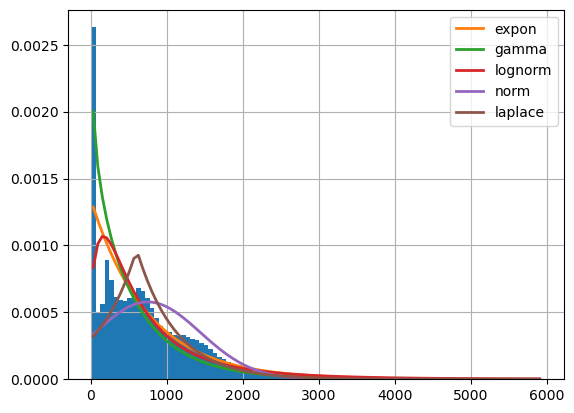

In [29]:
f = Fitter(train_data['num_sold'], distributions=['norm', 'lognorm', 'laplace', 'expon', 'gamma'])
f.fit()
print('Distribution of original training data:')
f.summary()
lognorm_params = f.fitted_param['lognorm']

In [30]:
from sklearn.model_selection import train_test_split
train_data['num_sold'] = np.log1p(train_data['num_sold'])
X = train_data.drop(['num_sold'], axis=1)
y = train_data['num_sold']
test = test_data.drop(['id'],axis=1)

# Split datainto training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))

In [33]:
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(X_test)
unlabeled_test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
target = 'num_sold'
predictors = X.columns.tolist()

In [35]:
aml = H2OAutoML(max_models=20, seed=SEED, max_runtime_secs=3600, sort_metric='RMSE')
aml.train(x=predictors, y=target, training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),18/20
# GBM base models (used / total),7/7
# XGBoost base models (used / total),6/6
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),3/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [36]:
lb = aml.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250103_93053,0.0538245,0.00289707,0.042776,0.0089339,0.00289707
XGBoost_3_AutoML_1_20250103_93053,0.0545962,0.00298075,0.0433788,0.0091466,0.00298075
StackedEnsemble_BestOfFamily_1_AutoML_1_20250103_93053,0.0549795,0.00302274,0.0436426,0.0091419,0.00302274
GBM_2_AutoML_1_20250103_93053,0.0559731,0.00313298,0.0443611,0.009269,0.00313298
GBM_3_AutoML_1_20250103_93053,0.056123,0.00314979,0.0444688,0.00933504,0.00314979
XGBoost_grid_1_AutoML_1_20250103_93053_model_2,0.0563477,0.00317506,0.0445818,0.00942345,0.00317506
GBM_1_AutoML_1_20250103_93053,0.0565027,0.00319256,0.0448842,0.00937493,0.00319256
GBM_5_AutoML_1_20250103_93053,0.0565096,0.00319334,0.0447609,0.0093692,0.00319334
GBM_grid_1_AutoML_1_20250103_93053_model_2,0.0572408,0.00327651,0.0452866,0.00945486,0.00327651
XGBoost_2_AutoML_1_20250103_93053,0.0575632,0.00331353,0.0454852,0.00979415,0.00331353


In [41]:
y_preds_h2o = aml.leader.predict(unlabeled_test)
y_preds = y_preds_h2o.as_data_frame()
y_preds

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


,predict
0,5.062378
1,6.761786
2,6.561698
3,5.943941
4,6.103047
...,...
98545,5.895812
98546,7.752683
98547,7.518138
98548,6.963615


In [42]:
y_preds['predict'] = np.expm1(y_preds['predict'])
y_preds

,predict
0,156.965777
1,863.184343
2,706.471771
3,380.435255
4,446.218538
...,...
98545,362.511740
98546,2326.809650
98547,1840.136724
98548,1056.449195


In [43]:
# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': y_preds['predict']})
submission.to_csv('submission.csv', index=False)
print(submission.head())

       id    num_sold
0  230130  156.965777
1  230131  863.184343
2  230132  706.471771
3  230133  380.435255
4  230134  446.218538
